In [2]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import random, os
from datetime import datetime, timedelta

# Derivatives Case Study

In [3]:
# An example strategy
# Competitor's code should output a data frame in the same format

sample = pd.DataFrame({
        'Datetime': ['2023-04-03 13:30:09.298764643','2023-04-03 14:19:55.423098372','2023-04-12 15:56:06.658071879',
                    '2023-04-19 14:44:16.427517766', '2023-05-16 18:39:15.484248296', '2023-06-07 14:48:53.707688555','2023-06-23 19:51:07.274959614',
                    '2023-04-06 13:36:26.873530500'],
        'Option Symbol': ['SPX   230421P03760000',
                          'VIX   230419P00020000',
                          'SPX   230519P03795000',
                          'VIX   230621C00025000',
                          'VIX   230719C00023000',
                          'SPX   230818C04625000',
                          'SPX   230818C04625000',
                          'SPX   230421P03760000',
                          ],
        'Action': ['S','B','B', 'S', 'B','S', 'B','B'],
        'Order size': [1,1,1, 1, 1, 1, 1, 1]
})
sample = sample.sort_values(by='Datetime')
sample=sample.reset_index(drop=True)
print(sample)

                        Datetime          Option Symbol Action  Order size
0  2023-04-03 13:30:09.298764643  SPX   230421P03760000      S           1
1  2023-04-03 14:19:55.423098372  VIX   230419P00020000      B           1
2  2023-04-06 13:36:26.873530500  SPX   230421P03760000      B           1
3  2023-04-12 15:56:06.658071879  SPX   230519P03795000      B           1
4  2023-04-19 14:44:16.427517766  VIX   230621C00025000      S           1
5  2023-05-16 18:39:15.484248296  VIX   230719C00023000      B           1
6  2023-06-07 14:48:53.707688555  SPX   230818C04625000      S           1
7  2023-06-23 19:51:07.274959614  SPX   230818C04625000      B           1


In [4]:
'''
#######
The functions associated with checking that the provided dataframe of trades
is consistent with the CQF Derivatives Standard
#######
'''

"""
valid_option_expiry - Given an option expiry date returns if the format is
consistent with the options data format for date expiry

Returns: True if option name is of a valid name, otherwise False
"""
def valid_option_expiry(expiry_date : str) -> bool:
  try:
    _ = datetime.strptime(expiry_date, "%y%m%d")
  except:
    return False
  return True


"""
parse_to_datetime - Tries to parse a the 'DateTime' column of the dataFrame into
the datetime type

Returns: Provided dataFrame with the 'DateTime' column in the DateTime type,
         if impossible returns None
"""
def parse_to_datetime(df: pd.DataFrame) -> (None | pd.DataFrame):
  try:
    df["Datetime"] = pd.to_datetime(df["Datetime"])
    return df
  except:
    return None


"""
check_format - Given a dataframe checks if it is consistent with the CQF
derivatives constraints placed on the trading dataframe

Throws: Throws an assertion error if data is inconsistent
"""
def check_format(df: pd.DataFrame, start_date: datetime = datetime(2023, 3, 1),
                 end_date: datetime = datetime(2023, 6, 30)) -> None:
  df = parse_to_datetime(df)
  # Static Checks
  assert df is not None, "'DateTime' column either doesn't exist or can't be"+\
  " converted to datetime type."
  assert df["Datetime"].is_monotonic_increasing,\
  "Trades are not sequentially ordered"

  # Iterate over the trades to enforce constraints
  for i in range(df.shape[0]):
    row = df.iloc[i]
    action, date = row["Action"], row["Datetime"]
    tickerLine = ' '.join(row["Option Symbol"].split()).split(" ")
    assert len(tickerLine) == 2, "Invalid Option Symbol Format, check doc for format specs"
    ticker, rest = tickerLine
    order_type, expiry_date = rest[6], rest[:6]
    assert action in ["B", "S"], "Action not B or S"
    assert isinstance(date, datetime),\
     "Datetime not in recognizable format"
    assert ticker in ["VIX", "SPX"], "Ticker not VIX or SPX"
    assert len(rest) == 15, "Price not padded to 8 digits"
    #assert start_date <= date <= end_date,\


    #"Date is not in acceptable time frame"
    assert order_type in ["P", "C"], "Type of Option is not P or C"
    assert valid_option_expiry(expiry_date), "Expiry Date is invalid"

In [5]:
#Checking our sample test case
check_format(sample, end_date=datetime(2023, 9, 30))

In [7]:
#initialize market data and set proper column data types (particularly for date)
spx_options = pd.read_csv('./CQF derivs data/SPX options.csv')
spx_options["ts_recv"] = pd.to_datetime(spx_options["ts_recv"])
spx_ids = pd.read_csv('./CQF derivs data/SPX options instrument ids.csv')
spx_data = pd.read_csv('./CQF derivs data/S_P 500 data.csv')
spx_data["date"] = pd.to_datetime(spx_data["date"])
vix_options = pd.read_csv('./CQF derivs data/VIX options.csv')
vix_options["ts_recv"] = pd.to_datetime(vix_options["ts_recv"])
vix_ids = pd.read_csv('./CQF derivs data/VIX options instrument ids.csv')
vix_data = pd.read_csv('./CQF derivs data/VIX data.csv')
vix_data["date"] = pd.to_datetime(vix_data["date"])

# Derivatives Back-Tester

In [8]:
'''
Helper Functions to calculate_pnL
'''

"""
calculate_margin_req - Given the strike, initial price and volume will calculate
the margin requirement.

Returns: Margin requirement as an integer
"""
def calculate_margin_req(strike, price, option_volume):
    return abs(option_volume)*((price + 0.1*strike)*100)


"""
buy_action - Executes a buy trade (if possible) on your portfolio

Returns: Modified cash, margin and holdings
"""
def buy_action(matching_option, option_symbol, order_size, expiry_date, margin,
               cash, holdings, strike):
  ###print("B")
  unit_price, total_volume = matching_option['ask_px_00'].values[0]/1e9, matching_option['ask_sz_00'].values[0]
  total_price = order_size * unit_price

  # Check if order is even viable
  ###print("order size < total vol?" , order_size, " < ", total_volume, ", AND total price < cash - margin?", total_price, " < ", cash - margin)
  if (order_size <= total_volume) & (total_price <= (cash - margin)):
    cash -= total_price
    # Checking if we are modifying an existing holding
    if option_symbol in holdings:
      ###print("\t EXISTING option symbol, clear short")
      options_info = holdings[option_symbol]
      reduce_margin = options_info[1] < 0

      # Reducing margin
      if reduce_margin:
        margin_freed_volume = min(abs(options_info[1]), order_size)
        freed_margin = calculate_margin_req(strike, options_info[0], margin_freed_volume)
        margin = max(0, margin-freed_margin)

      # Adjusting the existing holding
      adjusted_initial_price = options_info[0] if options_info[1] < 0 else\
       (options_info[0]*options_info[1] + unit_price*order_size)/(order_size + options_info[1])
      holdings[option_symbol] = [adjusted_initial_price, options_info[1]+order_size,
                  options_info[2], options_info[3]]
    else:
      ###print("\t no option symbol, new long")
      holdings[option_symbol] = [unit_price, order_size, expiry_date, strike]
  elif(order_size > total_volume):
    print("Order too big, cancelled")
  else:
    print("Not enough liquidity")
  ###print(holdings)
  ###print(cash)

  return (holdings, cash, margin)


"""
short_action - Executes a short(sell) trade if possible

Returns: Modified cash, holdings and margin
"""
def short_action(matching_option, option_symbol, order_size, date_exp, margin,
                cash, holdings, strike):
  unit_earn, total_volume = matching_option['bid_px_00'].values[0]/1e9, matching_option['bid_sz_00'].values[0]
  total_earnings = order_size * unit_earn
  # Check if order is even viable
  if (order_size <= total_volume) & (total_earnings <= (cash - margin)):
    cash += total_earnings
    # Checking if we are modifying an existing holding
    if option_symbol in holdings:
      options_info = holdings[option_symbol]
      reduce_margin = options_info[1] > 0
      real_margin_volume = 0
      initial_price = unit_earn
      # Are we closing a long position?
      if reduce_margin:
        real_margin_volume = abs(options_info[1] - margin) if options_info[1] < margin else 0
      else:
        # If we have some margin already, we need to dilute the initial price so final margin calcs are right
        initial_price = (options_info[0]*abs(options_info[1]) + unit_earn*order_size)/\
         (order_size + abs(options_info[1]))
        real_margin_volume = order_size
      # Calculating real added margin
      margin += calculate_margin_req(strike, options_info[0], real_margin_volume)

      # Adjusting the existing holding
      holdings[option_symbol] = [initial_price, options_info[1]-order_size,
                  options_info[2], options_info[3]]
    else:
      margin += total_earnings
      holdings[option_symbol] = [unit_earn, -order_size, date_exp, strike]
  ###print("S")
  ###print(holdings)
  ###print(cash)

  return (holdings, cash, margin)


"""
parsing_input - Meant to parse a row of csv data and get the date, option info and order type

Returns: date, option_symbol, action, order_size, ticker, date_exp, order_type
"""
def parsing_input(row):
  date = pd.to_datetime(row['Datetime'])
  option_symbol = row['Option Symbol']
  action = row['Action']
  order_size = row['Order size']
  ticker, rest = ' '.join(option_symbol.split()).split(" ")
  date_exp = datetime.strptime(rest[:6], "%y%m%d")
  order_type = rest[6]
  strike = int(rest[7:])/1000
  return date, option_symbol, action, order_size, ticker, date_exp, order_type, strike


"""
find_option - Uses ticker, option symbol and expiry date to find specific contract

Returns: matching option data
"""
def find_option(ticker, option_symbol, date, combined_market_options):
  id_list = spx_ids if ticker == 'SPX' else vix_ids
  try:
      instrument_id = id_list.loc[(id_list['raw_symbol'] == option_symbol) &\
                                  (id_list['date'] == date.date().strftime('%Y-%m-%d')), 'instrument_id'].values[0]
      # Dropping a useless duplicate index column
      combined_market_options = combined_market_options.drop(columns=['Unnamed: 0'])
      matching_option =\
        combined_market_options.loc[(combined_market_options['ts_recv'] == str(date))
        & (combined_market_options['instrument_id'] == instrument_id)]
      return matching_option
  except:
      raise AssertionError('Matching instrument id or matching option not found')


"""
execute_options - Executes options that expired before final_date that are in
the holdings given the options data, ticker, holdings, cash and current margin

Returns: holdings, cash, margin after being cleared of expired options and
         adjusted accordingly
"""
def execute_options(holdings, margin, cash, current_date, ticker):
  #Find options that have expired - to be executed at expiration
  expired_holds = [option_holding for option_holding in holdings if holdings[option_holding][2] < current_date]

  for option_holding in expired_holds:
    ###print(str(option_holding)+" EXPIRED!!!")
    init_price, option_volume, expiry_date, strike = holdings[option_holding]

    #Define ticker (VIX or SPX)
    if("V" in option_holding):
      ticker="VIX"
    else:
      ticker="SPX"

    #Define if call or put
    if("C" in option_holding):
      call=True
    else:
      call=False

    #Select correct dataset to use
    option_data = spx_data if ticker == "SPX" else vix_data
    closing_option = option_data.loc[option_data['date'] == expiry_date.date().strftime('%Y-%m-%d')]

    #If call, settle at max(spot-strike, 0)
    if(call):
      cash_settlement = max(closing_option['close'].values[0] - strike, 0)
    #If put, settle at max(strike-spot,0)
    if(not call):
      cash_settlement = max(strike-closing_option['close'].values[0], 0)

    #Print statements for debugging
    ###print("SPOT "+str(closing_option['close'].values[0]))
    ###print("STRIKE " + str(strike))
    ###print("SETTLE PRICE "+str(cash_settlement))

    # Free up margin for offsetting positions
    if option_volume < 0:
      freed_margin = calculate_margin_req(strike, init_price, option_volume)
      margin = max(0, margin-freed_margin)
    cash += cash_settlement * option_volume
    ###print("Proceeds "+str(cash_settlement * option_volume))
    del holdings[option_holding]
    ###print("FORCED SETTLED OPTION", option_holding, "FOR", cash_settlement * option_volume)

  return holdings, cash, margin


In [9]:
"""
clear_options - takes list of unexpired holdings, margin, cash, and last_date
Sells options for last market price

If market has enough bid/ask volume to buy your existing holdings, then sell for the most recent mid-price ([bid+ask]/2)
If your holdings are too large for market to handle, sell for 10% illiquidity discount to most recent mid-price

"""

def clear_options(holdings, margin, cash, last_date, ticker):
  #CLEARING PORTFOLIO
  holding_copy = [hold for hold in holdings]
  for option_holding in holding_copy:
    #FINDING OPTION ID
    init_price, option_volume, expiry_date, strike = holdings[option_holding]
    option_id=option_holding
    ###print("OPTION ID: "+str(option_id))

    #Determining if VIX or SPX
    if("V" in option_id):
      ticker="VIX"
    else:
      ticker="SPX"

    #Selecting correct dataset
    id_data = spx_ids if ticker == "SPX" else vix_ids
    price_data = spx_options if ticker == "SPX" else vix_options

    #rows where option_ID matches
    try1 = id_data.loc[(id_data['raw_symbol'] == option_id)]
    ###print(try1)

    idx = try1[try1['date']==last_date.date().strftime('%Y-%m-%d')].index
    if len(idx) == 0:
       idx = -1
       print("NO DATA FOUND")
    else:
      idx = idx.values[0]


    #Finding last market mid-price and depth
    price=0
    size=0
    while (price<=0) & (idx >= 0):
        instrument_id = try1['instrument_id'][idx]
        #print(str(instrument_id) +" | "+str(try1['date'][idx]))


        matched = price_data.loc[(price_data['instrument_id']== instrument_id)]

        #x = pd.DataFrame(matched['ts_recv'].dt.date)

        matched = pd.DataFrame(matched)
        matched['date'] = matched['ts_recv']
        matched['date'] = matched['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        matched = matched.drop_duplicates(subset='date', keep='last')

        found_data=matched.loc[(matched['date'] == try1['date'][idx])]

        if(len(found_data!=0)):
            ###print(found_data)
            #Determining last mid-price
            price=1/2*(found_data['bid_px_00'].values[0]+found_data['ask_px_00'].values[0])
            #Determining market depth
            size=max(found_data['bid_sz_00'].values[0],found_data['ask_sz_00'].values[0])
        idx -=1

    #Converting to $ price
    price=price*1e-9
    #Change price based on if currently long or short and liquidity
    if(option_volume>0):
        if(option_volume<=size):
          price=price
        else:
          price=.9*price
    else:
        if(-option_volume>size):
          price=1.1*price
        else:
          price=price
    ###print("Price: "+str(price))
    ###print("Qty: "+str(option_volume))
    ###print("Sale value: "+str(price*option_volume))

    #Close all options at found price
    cash += price * option_volume
    del holdings[option_holding]

  return holdings, cash, margin






In [11]:
def check_pnl(positions: pd.DataFrame, initial_cash=1000000,
              last_date: datetime = datetime(2023, 6, 30)): # holding list, pnl
  pnl = 0
  cash = initial_cash
  margin = 0

  holding_log = []

  """
  holdings is of the format:
  {
    option_symbol : [initial_price, size, expiry_date, strike]
  }
  """
  holdings = {}
  combined_market_options = pd.concat([spx_options, vix_options])
  if positions.empty:
    return holding_log, 0
  # Iterate on the user provided trades
  #sort positions by date
  positions = positions.sort_values(by='Datetime')
  positions = positions.reset_index(drop=True)

  ###print(positions)
  for index, row in positions.iterrows():
      date, option_symbol, action, order_size,\
      ticker, date_exp, option_type, strike = parsing_input(row)
      matching_option = find_option(ticker, option_symbol,
                                        date, combined_market_options)

      # Handle buy/short cases separately
      match action:
        case 'B':
          #print("BUY")
          holdings, cash, margin = buy_action(matching_option,
                                      option_symbol, order_size, date_exp,
                                      margin, cash, holdings, strike)

        case 'S':
          #print("SELL")
          holdings, cash, margin = short_action(matching_option, option_symbol,
                                                order_size, date_exp, margin,
                                                cash, holdings, strike)

      holding_log.append((holdings, cash, margin))

  # Execute expired options
  holdings, cash, margin = execute_options(holdings, margin, cash, last_date, ticker)
  holding_log.append((holdings, cash, margin))

  #Sell remaining open options
  holdings, cash, margin = clear_options(holdings, margin, cash, last_date, ticker)
  holding_log.append((holdings, cash, margin))

  pnl = cash-initial_cash
  return holding_log, pnl

In [12]:
def backtest(positions: pd.DataFrame,
             start_date: datetime=datetime(2023, 3, 1),
             end_date: datetime=datetime(2023, 6, 30)) -> float:
  check_format(positions, start_date=start_date, end_date=end_date)
  drop_list = []
  for i in range(positions.shape[0]):
    row = positions.iloc[i]
    date = row["Datetime"]
    if start_date <= date <= end_date:
        continue
    else:
      drop_list.append(i)
  positions = positions.drop(drop_list)
  holding_iters, pnl = check_pnl(positions, last_date=end_date)
  return holding_iters, pnl
  #return check_pnl(positions, last_date=end_date)

/var/folders/vj/mvnpdhvs2clgd_qwm14f936w0000gn/T/ipykernel_94854/1914057925.py:63: RuntimeWarning: overflow encountered in scalar add
  price=1/2*(found_data['bid_px_00'].values[0]+found_data['ask_px_00'].values[0])
/var/folders/vj/mvnpdhvs2clgd_qwm14f936w0000gn/T/ipykernel_94854/1914057925.py:63: RuntimeWarning: overflow encountered in scalar add
  price=1/2*(found_data['bid_px_00'].values[0]+found_data['ask_px_00'].values[0])
/var/folders/vj/mvnpdhvs2clgd_qwm14f936w0000gn/T/ipykernel_94854/1914057925.py:63: RuntimeWarning: overflow encountered in scalar add
  price=1/2*(found_data['bid_px_00'].values[0]+found_data['ask_px_00'].values[0])
/var/folders/vj/mvnpdhvs2clgd_qwm14f936w0000gn/T/ipykernel_94854/1914057925.py:63: RuntimeWarning: overflow encountered in scalar add
  price=1/2*(found_data['bid_px_00'].values[0]+found_data['ask_px_00'].values[0])


Text(0, 0.5, 'PNL')

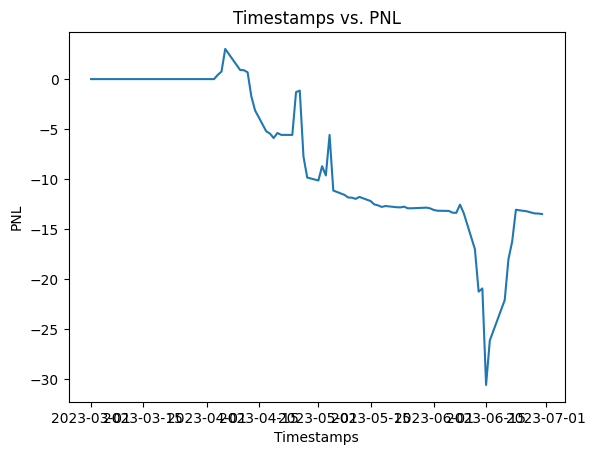

In [13]:
pnl_list = []

df = pd.DataFrame(vix_data)
for i in range(len(df)):
    timestamp_string = str(df['date'][i])
    format_string = "%Y-%m-%d %H:%M:%S"
    date = datetime.strptime(timestamp_string, format_string)
    ###print(datetime(date.year, date.month, date.day))
    holding, x = backtest(sample, end_date = datetime(date.year, date.month, date.day))
    pnl_list.append(x)

pd.DataFrame(df['date']).join(pd.DataFrame(pnl_list)).head(50)

plt.plot(df['date'], pnl_list)
plt.title('Timestamps vs. PNL')
plt.xlabel('Timestamps')
plt.ylabel('PNL')